In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
# Load images
img1 = cv2.imread('/content/download.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/2.jpeg', cv2.IMREAD_GRAYSCALE)

--- SIFT Keypoints ---


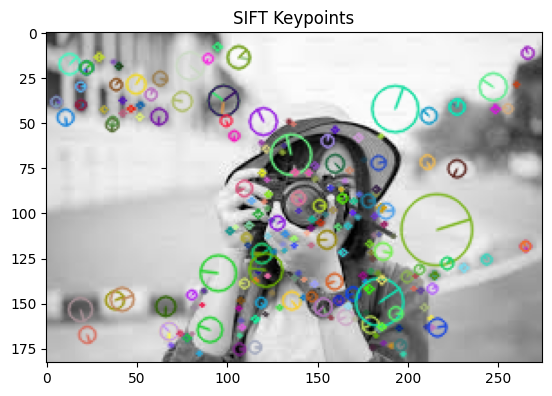

In [ ]:
# --- Interest Point Detection (SIFT) ---
# Load an image (replace 'your_image.jpg' with your image file)
img_sift = cv2.imread('/content/download.jpeg', cv2.IMREAD_GRAYSCALE) # Load as grayscale

if img_sift is None:
    print("Error: Could not load image for SIFT.")
else:
    # Create SIFT object
    sift = cv2.SIFT_create()

    # Detect keypoints
    keypoints_sift = sift.detect(img_sift, None)

    # Draw keypoints
    img_sift_keypoints = cv2.drawKeypoints(img_sift, keypoints_sift, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display the image with keypoints
    print("--- SIFT Keypoints ---")
    plt.imshow(cv2.cvtColor(img_sift_keypoints, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
    plt.title('SIFT Keypoints')
    plt.show()


--- Feature Matching (ORB + BFMatcher) ---


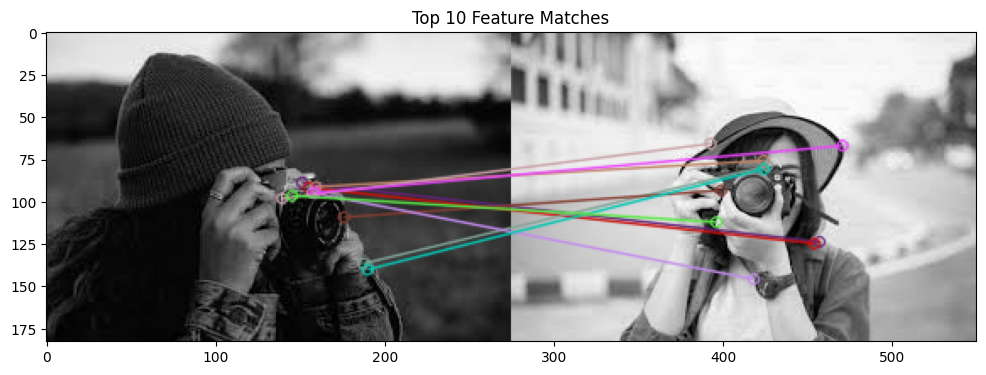

In [ ]:
# --- Feature Matching (ORB & BFMatcher) --- [cite: 2]
# Load two images for matching (replace with your images)
img1 = cv2.imread('/content/2.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('/content/download.jpeg', cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    print("Error: Could not load images for feature matching.")
else:
    # Create ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Create BFMatcher object [cite: 2]
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw first 10 matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display the matches
    print("\n--- Feature Matching (ORB + BFMatcher) ---")
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches)
    plt.title('Top 10 Feature Matches')
    plt.show()




--- Contour Detection (Watershed) ---


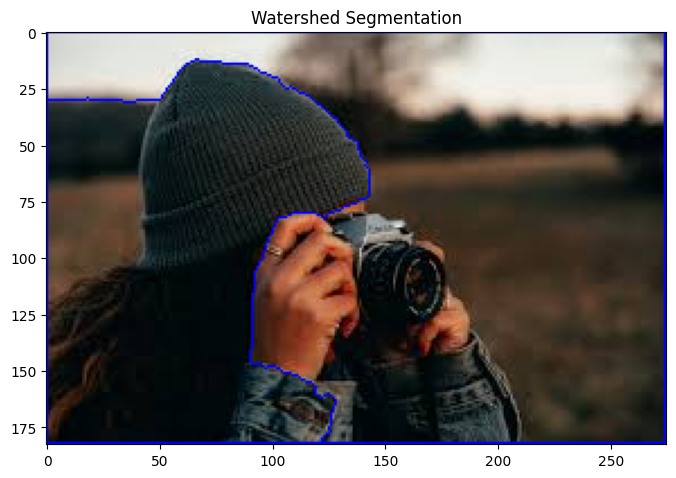

Is the first contour convex? False


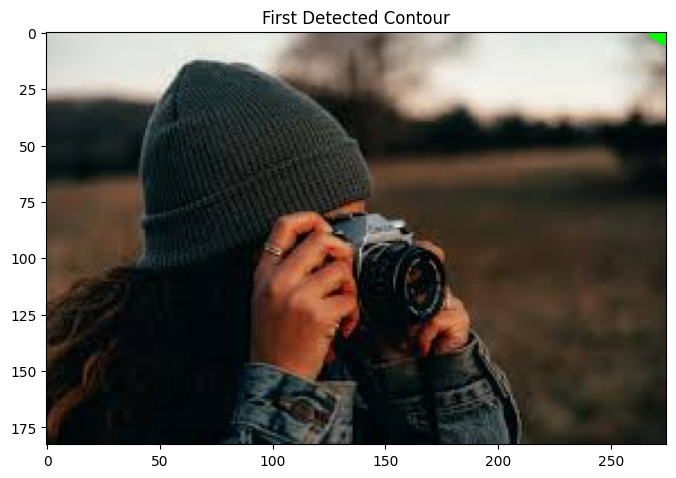

In [ ]:
# --- Contour Detection with Custom Seeds (Watershed Example) ---
# Load an image for contour detection (replace 'your_contour_image.jpg' with your image file)
img_contour_orig = cv2.imread('/content/2.jpeg')

# --- Add a check here to ensure the image loaded ---
if img_contour_orig is None:
    print("Error: Could not load image 'your_contour_image.jpg'. Please check the file path.")
else:
    print("\n--- Contour Detection (Watershed) ---")
    # Make a copy for watershed processing
    img_contour_watershed = img_contour_orig.copy()

    # Convert to grayscale
    gray_contour = cv2.cvtColor(img_contour_watershed, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    ret, thresh = cv2.threshold(gray_contour, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal (Morphological Opening)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (using distance transform)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed (modifies img_contour_watershed)
    markers = cv2.watershed(img_contour_watershed, markers)
    img_contour_watershed[markers == -1] = [255, 0, 0] # Mark boundaries in red

    # Display the watershed result
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(img_contour_watershed, cv2.COLOR_BGR2RGB))
    plt.title('Watershed Segmentation')
    plt.show()

    # --- Check Convexity (Example on first found contour) ---
    # Find contours from the thresholded image (thresh derived from the original gray image)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Check convexity of the first contour
        is_convex = cv2.isContourConvex(contours[0])
        print(f"Is the first contour convex? {is_convex}")

        # Draw the first contour ON A FRESH COPY of the original image
        img_draw_contour = img_contour_orig.copy() # Use the copy of the original
        cv2.drawContours(img_draw_contour, [contours[0]], -1, (0, 255, 0), 3) # Draw in green

        # Display the contour
        plt.figure(figsize=(8, 8))
        # This line should now work as img_draw_contour is a valid copy
        plt.imshow(cv2.cvtColor(img_draw_contour, cv2.COLOR_BGR2RGB))
        plt.title('First Detected Contour')
        plt.show()
    else:
        print("No contours found for convexity check.")

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Resize to smaller input to speed up training
transform = transforms.Compose([
    transforms.Resize(128),  # ResNet expects at least 128x128
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Use smaller subsets for fast training
train_subset = Subset(trainset, np.random.choice(len(trainset), 2000, replace=False))
test_subset = Subset(testset, np.random.choice(len(testset), 500, replace=False))

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False)


100%|██████████| 169M/169M [00:05<00:00, 28.9MB/s]


In [ ]:
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(arch='resnet18'):
    if arch == 'resnet18':
        model = models.resnet18(pretrained=True)
    else:
        model = models.resnet34(pretrained=True)

    # Modify last layer for 100 classes
    model.fc = nn.Linear(model.fc.in_features, 100)
    return model.to(device)


In [ ]:
import torch.optim as optim
import time

def train(model, epochs=1):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc * 100:.2f}%")
    return acc


In [ ]:
# ResNet18
start = time.time()
model18 = load_model('resnet18')
train(model18, epochs=10)
acc18 = evaluate(model18)
print("Time for ResNet18:", time.time() - start, "seconds\n")

# ResNet34
start = time.time()
model34 = load_model('resnet34')
train(model34, epochs=10)
acc34 = evaluate(model34)
print("Time for ResNet34:", time.time() - start, "seconds\n")

# Final Comparison
print("Final Comparison:")
print(f"ResNet18 Accuracy: {acc18 * 100:.2f}%")
print(f"ResNet34 Accuracy: {acc34 * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 3.8857
Epoch 2, Loss: 2.0985
Epoch 3, Loss: 1.0436
Epoch 4, Loss: 0.4719
Epoch 5, Loss: 0.2172
Epoch 6, Loss: 0.1119
Epoch 7, Loss: 0.0431
Epoch 8, Loss: 0.0351
Epoch 9, Loss: 0.0245
Epoch 10, Loss: 0.0351
Accuracy: 39.20%
Time for ResNet18: 34.09376287460327 seconds



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 4.1103
Epoch 2, Loss: 2.7839
Epoch 3, Loss: 1.9956
Epoch 4, Loss: 1.3474
Epoch 5, Loss: 1.0061
Epoch 6, Loss: 0.6441
Epoch 7, Loss: 0.4038
Epoch 8, Loss: 0.2797
Epoch 9, Loss: 0.2770
Epoch 10, Loss: 0.2775
Accuracy: 29.80%
Time for ResNet34: 47.34050917625427 seconds

Final Comparison:
ResNet18 Accuracy: 39.20%
ResNet34 Accuracy: 29.80%
